In [1]:
#generic import and constant definition list
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import astropy.constants as cons
from matplotlib.colors import LogNorm
import astropy.units as u
import pandas as pd
import scipy.optimize as opt
#all of the important fundamental constants are put into cgs units just for convenience
c=cons.c.cgs.value
G=cons.G.cgs.value
h=cons.h.cgs.value
hbar=cons.hbar.cgs.value
Msun=cons.M_sun.cgs.value
Rsun=cons.R_sun.cgs.value
Rearth=cons.R_earth.cgs.value
mp=cons.m_p.cgs.value
me=cons.m_e.cgs.value
mn=cons.m_n.cgs.value
kB=cons.k_B.cgs.value
mu_e=2 #mean mass per electron for He-core or C/O core composition
m_u = 1/cons.N_A.cgs.value #atomic mass unit in grams
from astropy.io import fits

In [3]:
def get_M_n_derivatives(A,Z,n_e,n_n):
    b1 = 0.991749
    b2 = 0.01911
    b3 = 0.000840
    b4 = 0.10175
    b5 = 0.000763
    M = m_u*(c**2)*(b1*A + b2*(A**(2/3))-b3*Z + b4*A*((0.5-Z/A)**2) + (b5*(Z**2))/(A**(1/3)))
    pfe = ((hbar**2)/(2*me))*(3*(np.pi**2)*n_e)**(2/3)
    efe = me*(c**2)*(np.sqrt(1+(pfe/(me*c))**2)-1)
    dMdZ = me*(c**2) - efe
    pfn = ((hbar**2)/(2*mn))*(3*(np.pi**2)*n_n)**(2/3)
    dMdA = mn*(c**2)*np.sqrt(1+(pfn/(mn*c))**2)
    return M, dMdZ, dMdA

In [4]:
def get_n_pressure_energydensity(x,m):
    lamb = hbar/(m*c) #reduced Compton wavelength of electron
    n = (x**3)/(3*(np.pi**2)*(lamb**3)) #electron number density
    phi = (1/(8*np.pi**2))*(x*np.sqrt(1+x**2)*(2*(x**2)/3 -1)+np.log(x+np.sqrt(1+x**2)))
    P = (m*(c**2)/(lamb**3))*phi
    chi = (1/(8*np.pi**2))*(x*np.sqrt(1+x**2)*(1+2*x**2) - np.log(x+np.sqrt(1+x**2)))
    eps = (m*(c**2)/(lamb**3))*chi
    return n, P, eps

In [46]:
def get_everything(A):
    Z = 3.54*np.sqrt(A)
    b1 = 0.991749
    b2 = 0.01911
    b3 = 0.000840
    b4 = 0.10175
    b5 = 0.000763
    #print(((b3+b4*(1-2*Z/A)-2*b5*Z/(A**(1/3)))*(m_u/me)+1)**2 -1)
    x_e = np.sqrt(((b3+b4*(1-2*Z/A)-2*b5*Z/(A**(1/3)))*(m_u/me)+1)**2 -1)
    n_e, P_e, eps_e = get_n_pressure_energydensity(x_e,me)

    x_n_sq = ((b1+2*b2*(A**(-1/3))/3 + b4*(0.25-(Z**2)/(A**2)) + b5*(Z**2)/(3*(A**(4/3))))*(m_u/mn))**2 -1
    x_n = np.sqrt(x_n_sq)
    n_n, P_n, eps_n = get_n_pressure_energydensity(x_n,mn)
    tiny_x_n_args = np.argwhere(x_n_sq<0)
    n_n[tiny_x_n_args] = 0
    P_n[tiny_x_n_args] = 0
    eps_n[tiny_x_n_args] = 0
        
    n = n_e*(A/Z)+n_n
    P = P_e + P_n
    M, dMdZ, dMdA = get_M_n_derivatives(A,Z,n_e,n_n)
    rho = (n_e*(M/Z) + eps_e - me*(c**2) + eps_n)/c**2
    Y_n = n_n/n
    return Z, rho, P, n, Y_n
    

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


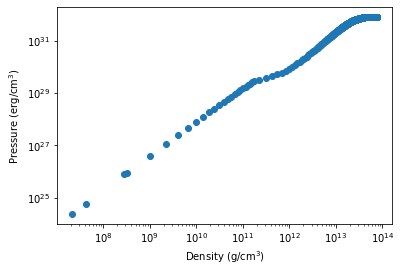

In [59]:
A = np.linspace(57,10000,5000)
Z, rho, P, n, Y_n = get_everything(A)
plt.scatter(rho,P)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Density (g/cm$^3$)')
plt.ylabel('Pressure (erg/cm$^3$)')
plt.show()